In [47]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [37]:
df = pd.read_csv("Brain_tumor/Brain Tumor.csv")
df['Image'] = df['Image'].astype(str) + ".jpg"
df['Class'] = df['Class'].astype(str)  # necesario para flow_from_dataframe

In [ ]:
# Ruta de carpetas de entrenamiento, validación y prueba
train_dir = "Brain_tumor/TRAIN"
val_dir   = "Brain_tumor/VAL"
test_dir  = "Brain_tumor/TEST"

#Función que solo deja en el CSV las imágenes que realmente están en la carpeta
def filter_df(directory, df):
    files = set(os.listdir(directory))
    return df[df['Image'].isin(files)]


#Aplicar la función a cada conjunto

df_train = filter_df(train_dir, df)
df_val   = filter_df(val_dir, df)
df_test  = filter_df(test_dir, df)


In [41]:
img_size = (150, 150) #Tamaño al que se redimensionarán las imágenes
batch_size = 32 #Cuántas imágenes por lote

#Normalización de imágenes dividiendo por 255

train_gen = ImageDataGenerator(rescale=1./255)
val_gen   = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

#Cargar imágenes y etiquetas desde el DataFrame filtrado

train = train_gen.flow_from_dataframe(df_train, train_dir, x_col='Image', y_col='Class',
                                      target_size=img_size, batch_size=batch_size, class_mode='binary')

val   = val_gen.flow_from_dataframe(df_val, val_dir, x_col='Image', y_col='Class',
                                    target_size=img_size, batch_size=batch_size, class_mode='binary')

test  = test_gen.flow_from_dataframe(df_test, test_dir, x_col='Image', y_col='Class',
                                     target_size=img_size, batch_size=1, class_mode='binary', shuffle=False)


Found 2633 validated image filenames belonging to 2 classes.
Found 565 validated image filenames belonging to 2 classes.
Found 564 validated image filenames belonging to 2 classes.


In [42]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)), #Primera capa convolucional = detecta bordes
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'), #Segunda capa convolucional = más patrones]
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'), #Tercera capa: más profunda
    MaxPooling2D(2,2),

    Flatten(), #Aplana la imagen a vector
    Dense(128, activation='relu'), #Capa densa con 128 neuronas
    Dropout(0.5), #Evita overfitting
    Dense(1, activation='sigmoid') #Salida binaria: 1=tumor, 0=no tumor
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Compilar modelo con función de pérdida binaria y métrica de precisión
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#Entrenar el modelo usando los generadores
history = model.fit(train, epochs=10, validation_data=val)


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.7102 - loss: 0.5714 - val_accuracy: 0.8195 - val_loss: 0.4447
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.7978 - loss: 0.4691 - val_accuracy: 0.8513 - val_loss: 0.3833
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 22s 262ms/step - accuracy: 0.8316 - loss: 0.3846 - val_accuracy: 0.8690 - val_loss: 0.3195
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 273ms/step - accuracy: 0.8572 - loss: 0.3444 - val_accuracy: 0.8407 - val_loss: 0.3547
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.8356 - loss: 0.3611 - val_accuracy: 0.8956 - val_loss: 0.2863
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - accuracy: 0.8818 - loss: 0.3012 - val_accuracy: 0.8956 - val_loss: 0.2825
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 287ms/step - accuracy: 0.8798 - loss: 0.2827 - val_accuracy: 0.8673 - val_loss: 0.3136
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 298ms/step - accuracy: 0.8882 - loss: 0.2758 - val_accuracy: 0.900

564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9328 - loss: 0.2070

🔍 Precisión en TEST: 0.9078
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


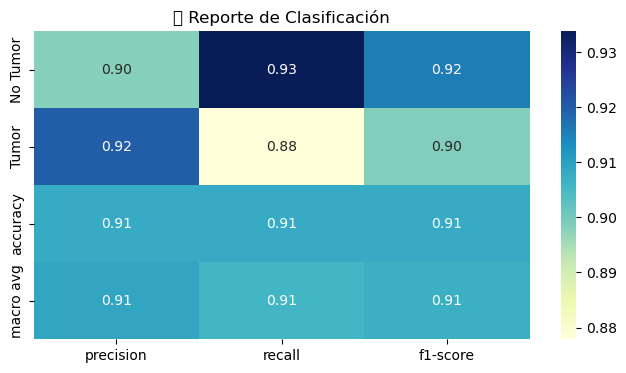

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


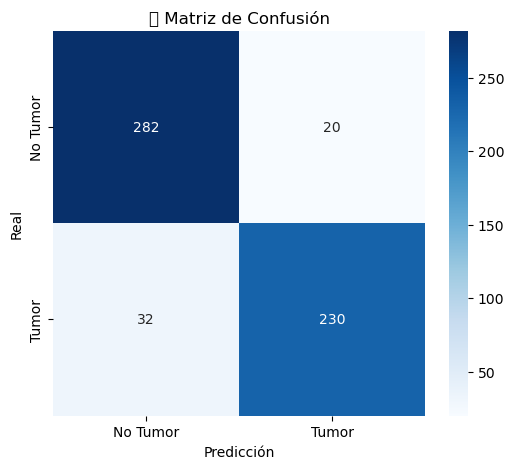

In [48]:

#Test 
loss, acc = model.evaluate(test)
print(f"\n🔍 Precisión en TEST: {acc:.4f}")

#Predicciones
y_pred = (model.predict(test) > 0.5).astype(int).flatten()
y_true = test.classes

#Reporte de clasificación
report = classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor'], output_dict=True)
report_df = pd.DataFrame(report).transpose()


plt.figure(figsize=(8,4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("📊 Reporte de Clasificación")
plt.show()

#Matriz de confusión 
cm = confusion_matrix(y_true, y_pred)
labels = ['No Tumor', 'Tumor']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("🧩 Matriz de Confusión")
plt.show()
